# Testing Softmax for accuracy

In [1]:
print("Importing torch...")
import torch
import torch.nn as nn
print("Importing HF...")
from transformers import AutoTokenizer, AutoModelForCausalLM
print("Importing python modules...")
from timehelp import time_start, time_end
from model_wrapper import Model, ModelFamily, MultipleChoiceStrategy
import re
print("Done!")

Importing torch...
Importing HF...
Importing python modules...
Done!


In [2]:
model = Model(ModelFamily.CodeGen1.mono["350M"])
model.configure(time=True)

[2024-05-06@16:58:57|model.device] Starting timer.
Configuring torch device...
Using device: cuda:0 aka cuda:0
[2024-05-06@16:58:57|model.device] Time elapsed: 23ms
[2024-05-06@16:58:57|model.tokenizer] Starting timer.
[2024-05-06@16:58:57|model.tokenizer] Time elapsed: 209ms
[2024-05-06@16:58:57|model.model] Starting timer.
Obtaining model...
[2024-05-06@16:59:01|model.model] Time elapsed: 3s 364ms


In [3]:
prompt = """for i in range"""
tokens = model.tokenize(prompt, time=True)

[2024-05-06@17:00:01|model.tokenize] Starting timer.
[2024-05-06@17:00:01|model.tokenize] Time elapsed: 106ms
Token count in input: 4


## Sort by logits

In [62]:
base_output = model.model_no_grad(input_ids=tokens["input_ids"])
base_logits = base_output.logits[:, -1, :]

logits_cpu = base_logits.cpu().detach().numpy().flatten()
indices_sorted = torch.argsort(base_logits).cpu().numpy().flatten()
sorted_pos = [(logits_cpu[idx], idx) for idx in range(len(indices_sorted))]
sorted_pos.sort(key=lambda x: x[0], reverse=True)

display_info = [
    [ logits, index, f"\"{model.decode([ index ])}\"" ]
    for logits, index
    in sorted_pos[:7]
]

print("\n".join(
    f"{rep}\tlogits={logits}\ttoken={index}"
    for logits, index, rep
    in display_info
))

"("	logits=27.749189376831055	token=7
" ("	logits=23.678096771240234	token=357
"(-"	logits=21.390438079833984	token=32590
"(("	logits=20.967388153076172	token=19510
"(_"	logits=19.828998565673828	token=28264
"():"	logits=18.87956428527832	token=33529
":"	logits=18.829797744750977	token=25


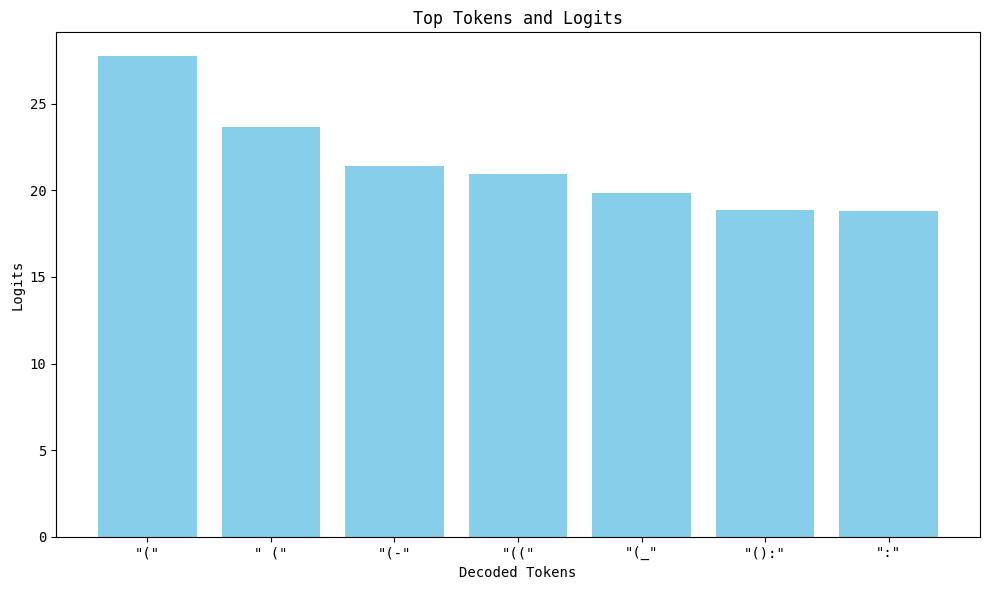

In [64]:
import matplotlib.pyplot as plt
def graph(display_info, kind):
    x_axis = [ rep for logits, index, rep in display_info ]
    y_axis = [ logits for logits, index, rep in display_info ]
    plt.figure(figsize=(10, 6))
    plt.bar(x_axis, y_axis, color="skyblue")
    plt.xlabel("Decoded Tokens")
    plt.ylabel(kind)
    plt.title(f"Top Tokens and {kind}")
    # plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels for better readability
    for tick in plt.gca().get_xticklabels():
        tick.set_fontname("monospace")
    plt.tight_layout()  # Adjust layout to prevent label cutoffs
    plt.show()

graph(display_info, "Logits")

## Sort by softmax

In [78]:
softmax = torch.nn.Softmax(dim=-1)

distribution = softmax(base_logits)
distribution

distribution_cpu = distribution.cpu().detach().numpy().flatten()
indices_sorted = torch.argsort(distribution).cpu().numpy().flatten()
sorted_pos = [(distribution_cpu[idx], idx) for idx in range(len(indices_sorted))]
sorted_pos.sort(key=lambda x: x[0], reverse=True)

display_info = [
    [ pr, index, f"\"{model.decode([ index ])}\"" ]
    for pr, index
    in sorted_pos[:7]
]

print("\n".join(
    f"{rep}\tPr={int(pr * 10000) / 100}%\ttoken={index}"
    for pr, index, rep
    in display_info
))

"("	Pr=97.92%	token=7
" ("	Pr=1.67%	token=357
"(-"	Pr=0.16%	token=32590
"(("	Pr=0.11%	token=19510
"(_"	Pr=0.03%	token=28264
"():"	Pr=0.01%	token=33529
":"	Pr=0.01%	token=25


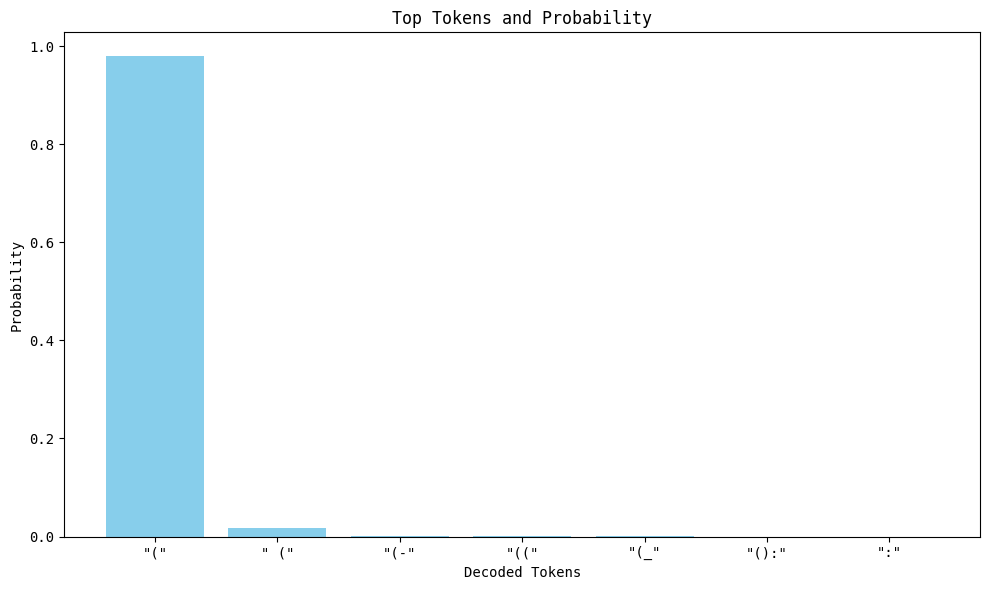

In [79]:
graph(display_info, "Probability")